In [1]:
from itertools import chain
import logging
import numpy as np
from pathlib import Path
from tqdm import tqdm
from omegaconf import DictConfig, OmegaConf, open_dict
from typing import Dict, List, Tuple, Any, Optional
import copy
import warnings 
import time
import matplotlib.pyplot as plt
import torch
import torch.cuda.amp as amp
from torch import Tensor, nn
import torch.nn.functional as F
import torch.optim as optim
import torch.distributed as dist
from torch.distributions.categorical import Categorical
from torch.nn.utils import clip_grad_value_
from torch.nn.parallel import DistributedDataParallel

import torchaudio
import torchaudio.transforms as T
from torchaudio.functional import mu_law_encoding, mu_law_decoding, DB_to_amplitude

import PIL
import os

from torch.utils.tensorboard import SummaryWriter
import submitit

# from tensorboardX import SummaryWriter
from torchvision.utils import make_grid, save_image
from torchvision import transforms
from tqdm import trange
# from ddpm.datasets import get_dataset
# from ddpm.trainers.base_trainer import BaseTrainer
# from ddpm.datasets.audio import create_dataloader, AudioDataset
# from ddpm.diffusion import GaussianDiffusionTrainer, GaussianDiffusionSampler, HeatDiffusionTrainer, HeatDiffusionSampler
# from ddpm.model import UNet
# from ddpm.score.both import get_inception_and_fid_score
# import wandb

In [115]:
import jax

In [2]:
waveform, sample_rate = torchaudio.load("samples/MIDI-Unprocessed_Schubert10-12_MID--AUDIO_20_R2_2018_wav.wav", True)
waveform = torch.mean(waveform, dim=0, keepdim=True)

In [3]:
n_fft = 510
win_length = None
hop_length = 128
n_mels = 128
audio_timesteps = 2**17 - 1
offset = 1000000
x_0 = waveform[:,offset:offset+audio_timesteps]
    # show model size
    
spectrogram = T.Spectrogram(
            n_fft= n_fft,
            win_length=win_length,
            hop_length=hop_length,
            center=True,
            pad_mode="reflect",
            power=2.,
            onesided=True,
    )

mel_spectrogram = T.MelSpectrogram(
            sample_rate=sample_rate,
            n_fft=n_fft,
            win_length=win_length,
            hop_length=hop_length,
            center=True,
            pad_mode="reflect",
            power=2.0,
            norm="slaney",
            onesided=True,
            n_mels=n_mels,
            mel_scale="htk",
    )

/home/bastienvandelft/.local/lib/python3.8/site-packages/torchaudio/functional/functional.py:507: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(


In [4]:
inverse_melscale = T.InverseMelScale(
         n_stft = 1024,
         n_mels = n_mels,
         sample_rate = sample_rate,
         f_min = 0.,
         max_iter = 100000,
         tolerance_loss = 1e-6,
         tolerance_change = 1e-9,
         mel_scale="htk",
         norm="slaney").cuda()

griffin_lim = T.GriffinLim(
         n_fft= n_fft,
         n_iter = 32,
         win_length = win_length,
         hop_length = hop_length,
         power = 2.,
         length = audio_timesteps,
         momentum = 0.99,
         rand_init= True).cuda()


power_to_db = T.AmplitudeToDB()
power_to_db.top_db = 80.0
power_to_db.amin = 1e-6
def db_to_power(x):
    return DB_to_amplitude(x, ref = 1., power = 1.0)


In [5]:
griffin_lim = griffin_lim.cuda()

In [6]:
x_melspec = mel_spectrogram(x_0)
x_spec = spectrogram(x_0)
x_db_mel = power_to_db(x_melspec)
x_db_spec = power_to_db(x_spec)


In [7]:
db_to_power(x_db_spec) - x_spec
 

tensor([[[ 9.5367e-07,  0.0000e+00,  0.0000e+00,  ...,  1.1921e-07,
           0.0000e+00,  1.9073e-06],
         [ 0.0000e+00,  0.0000e+00, -4.7684e-07,  ...,  4.7684e-07,
           0.0000e+00,  3.8147e-06],
         [ 0.0000e+00,  1.4901e-08, -9.5367e-07,  ...,  0.0000e+00,
          -3.8147e-06,  3.8147e-06],
         ...,
         [-1.4552e-11, -3.6380e-12,  1.0180e-05,  ...,  1.0225e-05,
           1.0224e-05,  4.1966e-06],
         [ 2.5466e-11,  2.7285e-12,  1.0210e-05,  ...,  1.0209e-05,
           1.0230e-05,  5.0647e-06],
         [-1.0914e-11, -1.7280e-11,  1.0233e-05,  ...,  1.0229e-05,
           1.0216e-05,  5.9600e-06]]])

In [225]:
# x_reverse_melscale = inverse_melscale(x_melspec.cuda())



In [8]:
x_griffin_lim = griffin_lim(x_spec.cuda())

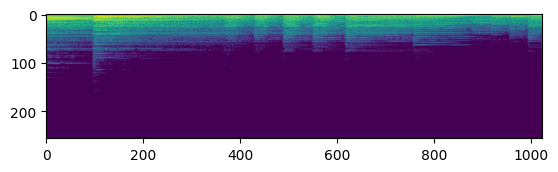

In [9]:
x_spec_img1 = (power_to_db(x_spec).cpu() + 1)/2
x_spec_img1 = x_spec_img1.permute(1,2,0).numpy()
# x_spec_np = np.array((x_spec_img*255), dtype=np.uint8)
plt.imshow(x_spec_img1)

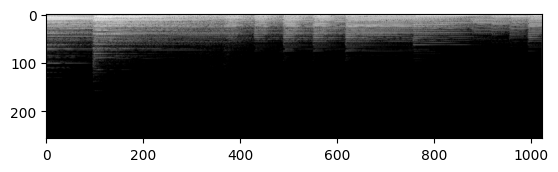

In [260]:
x_spec_img = (power_to_db(db_to_power(x_db_spec)).cpu() + 1)/2
x_spec_img = x_spec_img.permute(1,2,0).numpy()
# x_spec_np = np.array((x_spec_img*255), dtype=np.uint8)
plt.imshow(x_spec_img,cmap='gray')

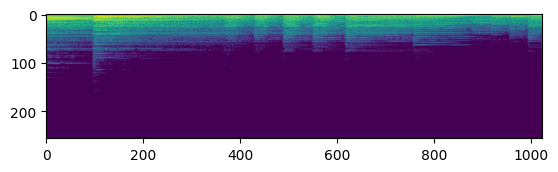

In [275]:
plt.imshow(x_spec_img)

In [267]:
a = torch.stack([torch.from_numpy(x_spec_img), torch.from_numpy(x_spec_img1)])

In [271]:
a.shape
grid = (make_grid(a.transpose(1,3)) + 1) / 2

In [272]:
grid

tensor([[[  0.5000,   0.5000,   0.5000,  ...,   0.5000,   0.5000,   0.5000],
         [  0.5000,   0.5000,   0.5000,  ...,   0.5000,   0.5000,   0.5000],
         [  0.5000,   0.5000,   3.0585,  ..., -10.1126,   0.5000,   0.5000],
         ...,
         [  0.5000,   0.5000,   4.4462,  ..., -11.7247,   0.5000,   0.5000],
         [  0.5000,   0.5000,   0.5000,  ...,   0.5000,   0.5000,   0.5000],
         [  0.5000,   0.5000,   0.5000,  ...,   0.5000,   0.5000,   0.5000]],

        [[  0.5000,   0.5000,   0.5000,  ...,   0.5000,   0.5000,   0.5000],
         [  0.5000,   0.5000,   0.5000,  ...,   0.5000,   0.5000,   0.5000],
         [  0.5000,   0.5000,   3.0585,  ..., -10.1126,   0.5000,   0.5000],
         ...,
         [  0.5000,   0.5000,   4.4462,  ..., -11.7247,   0.5000,   0.5000],
         [  0.5000,   0.5000,   0.5000,  ...,   0.5000,   0.5000,   0.5000],
         [  0.5000,   0.5000,   0.5000,  ...,   0.5000,   0.5000,   0.5000]],

        [[  0.5000,   0.5000,   0.5000,  ...

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


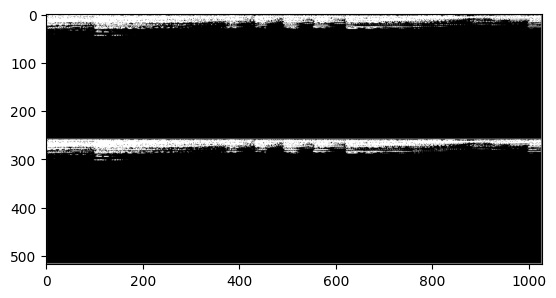

In [274]:
plt.imshow(grid.transpose(0,2))

In [10]:
%matplotlib inline
from IPython.display import Audio
Audio(x_griffin_lim.cpu().numpy(), rate=sample_rate)


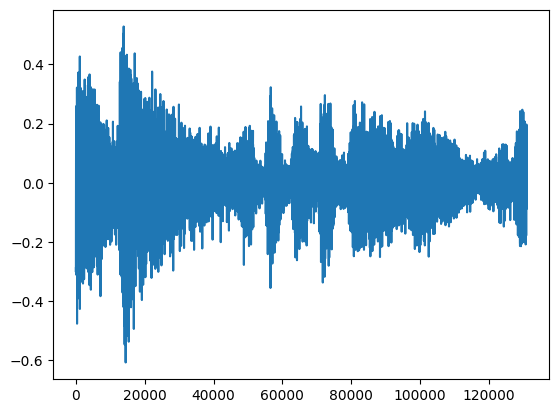

In [191]:
plt.plot(x_griffin_lim.squeeze().cpu().numpy())

In [2]:
############################################ IMAGE ##################

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# gta_train_transform =  transforms.Compose(
#     [   transforms.Resize([1052,1914]),
#         transforms.RandomCrop([1024,1904]),
#         transforms.Resize([256, 476]),
#         transforms.RandomCrop([256, 256]),
#         transforms.ToTensor(),
#     ]
# )

# cityscapes_transform = transforms.Compose(
#                 [   transforms.Resize([1024,2048]),
#                     transforms.Resize([256,512]),
#                     transforms.RandomCrop([256, 256]),
#                     transforms.ToTensor(),
#                 ]
#             )

In [4]:
# stream = open('ddpm/config/trainer/gta_trainer_ddib_V100.yaml', 'r')
# gta_trainer_config = yaml.safe_load(stream)
# stream = open('ddpm/config/trainer/cityscapes_trainer.yaml', 'r')
# cityscapes_trainer_config = yaml.safe_load(stream)


In [84]:
### IMAGENET
%load_ext autoreload
%autoreload 2
import os
import tllib
from tllib.vision.datasets.segmentation.gta5 import GTA5
import torch
import numbers
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
from torchvision.datasets import CIFAR10, Cityscapes
from ddpm.datasets.gta5 import GTA_Pretraining_Dataset
from ddpm.datasets.cityscape import Cityscapes_Pretraining_Dataset
from ddpm.datasets.imagenet import Imagenet_Dataset

from omegaconf import DictConfig, OmegaConf, open_dict
import yaml
from ddpm.diffusion import GaussianDiffusionTrainer, GaussianDiffusionSampler, HeatDiffusionTrainer, HeatDiffusionSampler
from ddpm.model import UNet
from ddpm.ddib_model import UNetModel
from ddpm.ddib_diffusion import GaussianDiffusion, SpacedDiffusion, _extract_into_tensor, space_timesteps, LossType, ModelMeanType, ModelVarType, get_named_beta_schedule
import importlib


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [104]:
imagenet_checkpoint = torch.load('/mnt/scitas/bastien/logs/IMAGENET/Imagenet_256ch_True_[\'motion_blur\']_x256_2023-07-14_19-17/ckpt_22000.pt')

# imagenet_checkpoint = torch.load('/mnt/scitas/bastien/logs/IMAGENET/2023-07-17_18-15/ckpt_10000.pt')
imagenet_config = DictConfig(imagenet_checkpoint['config'])

In [116]:
imagenet_cfg = {}
imagenet_cfg = imagenet_config
imagenet_cfg['trainer']['datapath'] = '/mnt/scitas/datasets/imagenet'
imagenet_cfg['trainer']['imagenet_256_ckpt'] = "/mnt/scitas/bastien/imagenet_diffusion/256x256_diffusion_uncond.pt"
imagenet_cfg['trainer']["open_ai_normalization"] = False
# imagenet_cfg['trainer']["split"] = "val"
imagenet_cfg = DictConfig(imagenet_cfg)

imagenet_train_transform =  transforms.Compose(
                    [transforms.ToTensor(),
                    transforms.Resize([256]),
                    transforms.CenterCrop(imagenet_cfg.trainer.img_size),
                     
                    ])

train_dataset_imagenet = Imagenet_Dataset(imagenet_cfg,transform = imagenet_train_transform)

In [41]:
# from PIL import Image
# img_path =  "/mnt/scitas/datasets/imagenet/val/n01440764/ILSVRC2012_val_00000293.JPEG"
# X = Image.open(img_path)
# X.load()
# X= X.convert("RGB")
# X_array = np.array(X)
# X_bis = X_array.astype(np.float32)/127.5 - 1
# X_tensor = imagenet_train_transform(X)

In [117]:
params_from_cfg = False
if params_from_cfg:
    channel_mult = imagenet_cfg.trainer.ch_mult
    image_size = imagenet_cfg.trainer.img_size
    if imagenet_cfg.trainer.mean_type == "EPSILON":
        model_mean_type = ModelMeanType.EPSILON
    elif imagenet_cfg.trainer.mean_type == "START_X":
        model_mean_type = ModelMeanType.START_X
    elif imagenet_cfg.trainer.mean_type == "PREVIOUS_X":
        model_mean_type = ModelMeanType.PREVIOUS_X
    else:
        raise NotImplementedError

    if imagenet_cfg.trainer.var_type == "LEARNED":
        model_var_type = ModelVarType.LEARNED
    elif imagenet_cfg.trainer.var_type == "FIXED_SMALL":
        model_var_type = ModelVarType.FIXED_SMALL
    elif imagenet_cfg.trainer.var_type == "FIXED_LARGE":
        model_var_type = ModelVarType.FIXED_LARGE
    elif imagenet_cfg.trainer.var_type == "LEARNED_RANGE":
        model_var_type = ModelVarType.LEARNED_RANGE
    else:
        raise NotImplementedError

    if imagenet_cfg.trainer.loss_type == "MSE":
        loss_type = LossType.MSE
    elif imagenet_cfg.trainer.loss_type == "RESCALED_MSE":
        loss_type = LossType.RESCALED_MSE
    elif imagenet_cfg.trainer.loss_type == "KL":
        loss_type = LossType.KL
    elif imagenet_cfg.trainer.loss_type == "RESCALED_KL":
        loss_type = LossType.RESCALED_KL
    else:
        raise NotImplementedError
    learn_sigma = False if model_var_type in [ModelVarType.FIXED_LARGE,ModelVarType.FIXED_SMALL] else True
    if channel_mult is None:
        if image_size == 512:
            channel_mult = (0.5, 1, 1, 2, 2, 4, 4)
        elif image_size == 256:
            channel_mult = (1, 1, 2, 2, 4, 4)
        elif image_size == 128:
            channel_mult = (1, 2, 2, 4, 8) #(1, 1, 2, 3, 4)
        elif image_size == 64:
            channel_mult = (1, 2, 3, 4)
        else:
            raise ValueError(f"unsupported image size: {image_size}")
    else:
        channel_mult = tuple(int(ch_mult) for ch_mult in channel_mult.split(","))

    attention_ds = []
    for res in imagenet_cfg.trainer.attention_resolutions.split(","):
        attention_ds.append(image_size // int(res))

    if imagenet_cfg.trainer.input_channel == 1:
        out_channels = 1
    else:
        out_channels = (3 if not learn_sigma else 6)
    net_model = UNetModel(imagenet_cfg.trainer.img_size,
                            in_channels = imagenet_cfg.trainer.input_channel,
                            model_channels = imagenet_cfg.trainer.ch, #128
                            out_channels = out_channels,
                            num_res_blocks = imagenet_cfg.trainer.num_res_blocks, #2
                            attention_resolutions = tuple(attention_ds),
                            dropout=imagenet_cfg.trainer.dropout,
                            channel_mult=channel_mult,
                            conv_resample=True,
                            dims=2,
                            num_classes=None,
                            use_checkpoint=False,
                            use_fp16=imagenet_cfg.trainer.use_fp16,
                            num_heads=imagenet_cfg.trainer.num_heads,
                            num_head_channels=imagenet_cfg.trainer.num_head_channels,
                            num_heads_upsample=-1,
                            use_scale_shift_norm=imagenet_cfg.trainer.use_scale_shift_norm,
                            resblock_updown=imagenet_cfg.trainer.resblock_updown,
                            use_new_attention_order=False)

else:
    attention_resolutions = [32,16,8]
    class_cond = False 
    diffusion_steps = 1000 
    image_size = 256 
    learn_sigma = True 
    noise_schedule = imagenet_cfg.trainer.beta_schedule 
    num_channels = 256 
    num_head_channels = 64 
    num_res_blocks = 2 
    resblock_updown = True 
    use_fp16 = True
    use_scale_shift_norm = True
    input_channels = 3
    model_var_type = ModelVarType.LEARNED_RANGE
    model_mean_type = ModelMeanType.EPSILON
    loss_type = LossType.RESCALED_MSE
    if imagenet_cfg.trainer.input_channel == 1:
        out_channels = 1
    else:
        out_channels = (3 if not learn_sigma else 6)
    net_model = UNetModel(image_size,
                    in_channels = input_channels,
                    model_channels = num_channels, #128
                    out_channels = out_channels,
                    num_res_blocks = num_res_blocks, #2
                    attention_resolutions = attention_resolutions,
                    dropout=0.,
                    channel_mult=(1, 1, 2, 2, 4, 4),
                    conv_resample=True,
                    dims=2,
                    num_classes=None,
                    use_checkpoint=False,
                    use_fp16=False,
                    num_heads=-1,
                    num_head_channels=num_head_channels,
                    num_heads_upsample=-1,
                    use_scale_shift_norm=use_scale_shift_norm,
                    resblock_updown=resblock_updown,
                    use_new_attention_order=False)

imagenet_model = UNetModel(image_size,
                    in_channels = input_channels,
                    model_channels = num_channels, #128
                    out_channels = out_channels,
                    num_res_blocks = num_res_blocks, #2
                    attention_resolutions = attention_resolutions,
                    dropout=0.,
                    channel_mult=(1, 1, 2, 2, 4, 4),
                    conv_resample=True,
                    dims=2,
                    num_classes=None,
                    use_checkpoint=False,
                    use_fp16=False,
                    num_heads=-1,
                    num_head_channels=num_head_channels,
                    num_heads_upsample=-1,
                    use_scale_shift_norm=use_scale_shift_norm,
                    resblock_updown=resblock_updown,
                    use_new_attention_order=False)

print("Unets instantiated.")

ckpt_imagenet = torch.load(imagenet_cfg.trainer.imagenet_256_ckpt)
net_model.load_state_dict(imagenet_checkpoint['ema_model'])
imagenet_model.load_state_dict(ckpt_imagenet)


# imagenet_model.convert_to_fp16()
imagenet_model.eval()
net_model.eval()
net_model = net_model.cuda(1)
imagenet_model = imagenet_model.cuda(3)
print("Models Loaded.")

Unets instantiated.
Models Loaded.


In [125]:
noise_schedule = 'linear'#imagenet_cfg.trainer.beta_schedule 
diffusion_steps = imagenet_cfg.trainer.num_timesteps
betas = get_named_beta_schedule(noise_schedule, diffusion_steps)
                                
diffusion = GaussianDiffusion(betas = betas,
                    model_mean_type = model_mean_type,
                    model_var_type = model_var_type,
                    loss_type = loss_type,
                    rescale_timesteps = False)


timesteps_respacing = "ddim100"

spaced_diffusion = SpacedDiffusion(use_timesteps=space_timesteps(diffusion_steps, timesteps_respacing),
                        betas=betas,
                        model_mean_type=model_mean_type,
                        model_var_type=model_var_type,
                        loss_type=loss_type,
                        rescale_timesteps=False,
                        )
new_betas = get_named_beta_schedule('linear', diffusion_steps)
new_spaced_diffusion = SpacedDiffusion(use_timesteps=space_timesteps(diffusion_steps, timesteps_respacing),
                        betas=new_betas,
                        model_mean_type=model_mean_type,
                        model_var_type=model_var_type,
                        loss_type=loss_type,
                        rescale_timesteps=False,
                        )

print("Diffusions instantiated")

Diffusions instantiated


In [121]:
image_0.min()

tensor(0.)

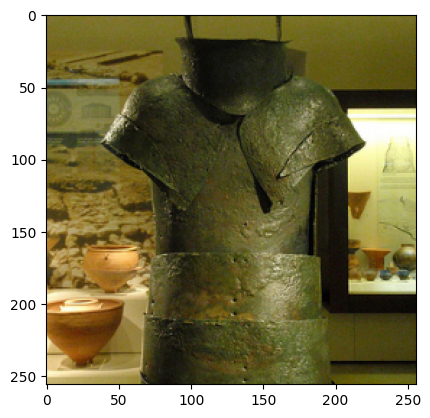

In [120]:
image_0 = train_dataset_imagenet[3][1]
sample = ((image_0 + 1) * 127.5).clamp(0, 255).to(torch.uint8)
plt.imshow(image_0.permute(1,2,0).numpy())

In [62]:
### TEST SAMPLING

In [88]:
ddpm_imagenet_sample = spaced_diffusion.ddim_sample_loop_progressive(imagenet_model,[4,3,256,256], clip_denoised=True)
ddpm_of_sampled_tensor = []
with torch.no_grad():
    for dic in tqdm(ddpm_imagenet_sample):
        ddpm_of_sampled_tensor.append(dic['sample'].cpu())


25it [00:12,  2.03it/s]


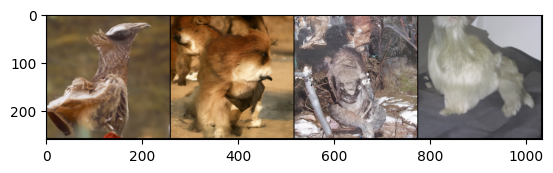

In [89]:
sample = ddpm_of_sampled_tensor[-1]
sample = ((sample + 1) * 127.5).clamp(0, 255).to(torch.uint8)
sample = make_grid(sample.cpu()).permute(1,2,0)
plt.imshow(sample)

In [ ]:
### Test Reverse Encoding

In [166]:
image_0[1].max()

tensor(1.)

In [92]:
sample.shape

torch.Size([260, 1034, 3])

In [134]:
inputs = image_0.unsqueeze(0).cuda(3)
inputs = ((inputs + 1) * 127.5).clamp(0, 255)/255
reverse_encoding = new_spaced_diffusion.ddim_reverse_sample_loop_progressive(imagenet_model,inputs ,clip_denoised=True)
ddpm_of_encoded_tensor = []
with torch.no_grad():
    for dic in tqdm(reverse_encoding):
        ddpm_of_encoded_tensor.append(dic['sample'].cpu())


100it [00:14,  6.98it/s]


In [135]:
inputs = ddpm_of_encoded_tensor[-1].cuda(3)
reverse_decoding = spaced_diffusion.ddim_sample_loop_progressive(imagenet_model,shape=[1,3,256,256],clip_denoised=True ,
                                                                 noise=inputs)
ddpm_of_decoded_tensor = []
with torch.no_grad():
    for dic in tqdm(reverse_decoding):
        ddpm_of_decoded_tensor.append(dic['sample'].cpu())



100it [00:14,  6.92it/s]


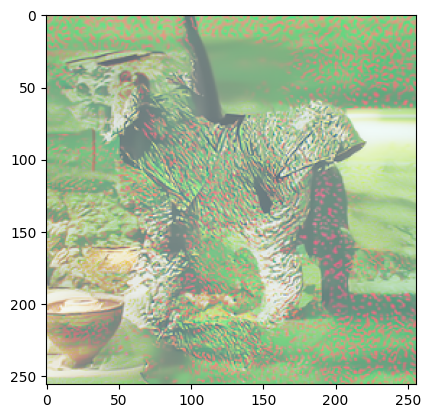

In [136]:
sample = ((ddpm_of_decoded_tensor[-1][0] + 1) * 127.5).clamp(0, 255).to(torch.uint8)
plt.imshow(sample.permute(1,2,0).numpy())

In [202]:
ddpm_of_decoded_tensor[-1][0]

tensor([[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 0.9993, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.9998]],

        [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 0.9991, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.9967],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 0.9991, 0.9955]],

        [[0.9959, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.

In [8]:
# def gta_transform(x,y):
#     f = transforms.ToTensor()
#     g = transforms.Resize((1024,1980))
#     return (f(x)), f(y)

train_dataset_gta = GTA_Pretraining_Dataset(gta_cfg,transform = gta_train_transform)
train_dataset_cityscape = Cityscapes_Pretraining_Dataset(cityscapes_cfg, transform = cityscapes_transform)


No split when using GTA


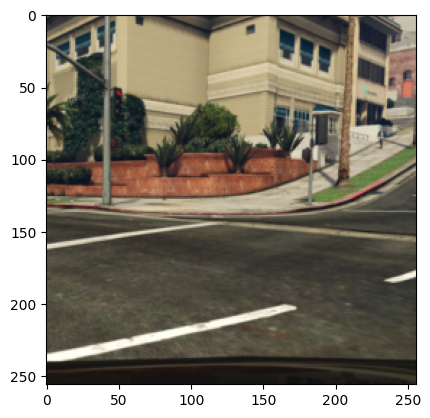

In [8]:
gta_a = train_dataset_gta[0]
plt.imshow(gta_a[1].permute(1,2,0).numpy())


In [24]:
cityscapes_checkpoint = torch.load('/mnt/scitas/bastien/logs/Cityscapes/Cityscape_Diffusion_128x_2023-04-18_10-55/ckpt_400000.pt')
cityscapes_config = DictConfig(cityscapes_checkpoint['config'])
train_dataset_cityscape = Cityscapes_Pretraining_Dataset(cityscapes_cfg, transform = cityscapes_transform)

In [25]:
cityscapes_checkpoint.keys()


dict_keys(['net_model', 'ema_model', 'sched', 'optim', 'step', 'x_T', 'config'])

In [9]:
gta_checkpoint = torch.load("/mnt/scitas/bastien/logs/GTA/ckpt_950000.pt")
gta_config = DictConfig(gta_checkpoint['config'])
train_dataset_gta = GTA_Pretraining_Dataset(gta_config,transform = gta_train_transform)

No split when using GTA


In [10]:
gta_config 

{'dataset': {'name': 'base_dataset'}, 'trainer': {'name': 'gta_diffusion', 'type': 'cityscape', 'platform': 'local', 'seed': 0, 'training_perc': 0.8, 'validation_perc': 0, 'train_clip_duration': 2, 'validation_clip_duration': 3, 'test_clip_duration': 3, 'results_dir': 'results', 'use_clearml': False, 'use_wandb': True, 'wandb_entity': 'bastienvd', 'ml_exp_name': 'GTA_Diffusion_x128', 'slurm': {'nodes': 2, 'gpus_per_node': 2, 'cpus_per_task': 10, 'mem': 72, 'timeout': 48, 'partition': 'gpu', 'qos': 'gpu', 'account': 'vita', 'reservation': 'vita-neurips'}, 'logdir': '/mnt/scitas/bastien/logs/GTA', 'sync_key': '${now:%Y-%m-%d_%H-%M}', 'output_dir': '${trainer.logdir}', 'checkpointpath': None, 'train': True, 'eval': False, 'datapath': '/mnt/scitas/datasets/gta5', 'dataset': 'GTA', 'split': 'all', 'corruption': None, 'corruption_severity': None, 'random_flip': False, 'original_img_size': [1052, 1914], 'first_crop': [1024, 1904], 'lower_image_size': [128, 238], 'img_size': [128, 128], 'input

In [11]:
gta_ema_model = UNet(
    T=gta_config.trainer.T, ch=gta_config.trainer.ch, ch_mult=OmegaConf.to_object(gta_config.trainer.ch_mult), 
        attn=OmegaConf.to_object(gta_config.trainer.attn),
        num_res_blocks=gta_config.trainer.num_res_blocks, dropout=gta_config.trainer.dropout, 
        input_channel=gta_config.trainer.input_channel, kernel_size=gta_config.trainer.kernel_size)



In [26]:
cityscapes_ema_model = UNet(
    T=cityscapes_config.trainer.T, ch=cityscapes_config.trainer.ch, ch_mult=OmegaConf.to_object(cityscapes_config.trainer.ch_mult), 
        attn=OmegaConf.to_object(cityscapes_config.trainer.attn),
        num_res_blocks=cityscapes_config.trainer.num_res_blocks, dropout=cityscapes_config.trainer.dropout, 
        input_channel=cityscapes_config.trainer.input_channel, kernel_size=cityscapes_config.trainer.kernel_size)



In [27]:
cityscapes_ema_model.load_state_dict(cityscapes_checkpoint['ema_model'])
cityscapes_ema_model = cityscapes_ema_model.cuda(2)

In [12]:
gta_ema_model.load_state_dict(gta_checkpoint['ema_model'])
gta_ema_model = gta_ema_model.cuda(3)


In [13]:
gta_ema_sampler = GaussianDiffusionSampler(
            gta_ema_model, gta_config.trainer.beta_1, gta_config.trainer.beta_T, gta_config.trainer.T, gta_config.trainer.img_size,
            gta_config.trainer.mean_type, gta_config.trainer.var_type).cuda(3)

In [28]:
from ddpm.ddib_utils import *
from ddpm.ddib_diffusion import GaussianDiffusion, SpacedDiffusion, ModelMeanType, ModelVarType, LossType, get_named_beta_schedule, space_timesteps
    
betas = get_named_beta_schedule("linear",1000)
model_mean_type = ModelMeanType.EPSILON
model_var_type = ModelVarType.FIXED_LARGE
loss_type = LossType.MSE

gta_diffusion = GaussianDiffusion(betas = betas,model_mean_type = model_mean_type ,model_var_type = model_var_type,
                                  loss_type= loss_type)
cityscapes_diffusion = GaussianDiffusion(betas = betas,model_mean_type = model_mean_type ,model_var_type = model_var_type,
                                  loss_type= loss_type)

In [24]:
gta_diffusion.p_sample_loop_progressive(gta_ema_model,[4,3,128,128])

<generator object GaussianDiffusion.p_sample_loop_progressive at 0x7f81ec4bbf20>

In [31]:
ddpm_gta_sample = cityscapes_diffusion.p_sample_loop_progressive(cityscapes_ema_model,[4,3,128,128])
ddpm_of_sampled_tensor = []
for dic in tqdm(ddpm_gta_sample):
    ddpm_of_sampled_tensor.append(dic['sample'].cpu())

1000it [04:05,  4.07it/s]


In [47]:
# ddim_gta_sample = gta_ema_sampler.p_sample_loop_progressive([4,3,128,128],  eta=0.)
ddpm_gta_sample = gta_diffusion.p_sample_loop_progressive(gta_ema_model,[4,3,128,128])
ddpm_of_sampled_tensor = []
for dic in tqdm(ddpm_gta_sample):
    ddpm_of_sampled_tensor.append(dic['sample'].cpu())

1000it [04:07,  4.04it/s]


torch.Size([132, 522, 3])


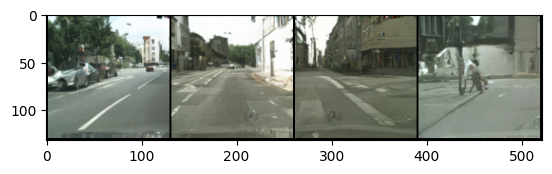

In [32]:
# Reversed Encoding
x_0 = ddpm_of_sampled_tensor[-1]
data = make_grid(x_0.cpu())
data = data.permute(1,2,0)
print(data.shape)
data_np = np.array((data*255), dtype=np.uint8)
plt.imshow(data_np)

In [33]:
ddim_gta_sample = gta_diffusion.ddim_sample_loop_progressive(cityscapes_ema_model,[4,3,128,128],clip_denoised=False,eta=0.)
liste_of_sampled_tensor = []
for dic in tqdm(ddim_gta_sample):
    liste_of_sampled_tensor.append(dic['sample'].cpu())

1000it [04:12,  3.96it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


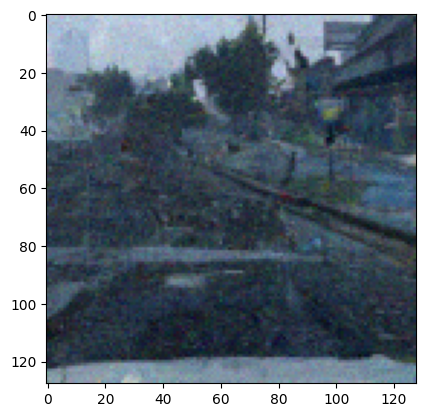

In [46]:
plt.imshow(liste_of_sampled_tensor[-1][3].cpu().permute(1,2,0).numpy())

In [21]:
spacediff_gta = SpacedDiffusion(use_timesteps=space_timesteps(1000, 'ddim100'), betas = betas,model_mean_type = model_mean_type ,model_var_type = model_var_type,
                                  loss_type= loss_type)

In [29]:
ddim_gta_sample = spacediff_gta.ddim_sample_loop_progressive(cityscapes_ema_model,[4,3,128,128],clip_denoised=False,eta=0.)
liste_of_sampled_tensor = []
for dic in tqdm(ddim_gta_sample):
    liste_of_sampled_tensor.append(dic['sample'].cpu())

100it [00:26,  3.83it/s]


torch.Size([132, 522, 3])


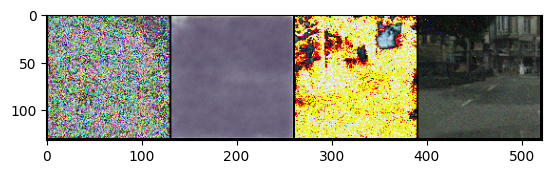

In [30]:
# Reversed Encoding
x_0 = liste_of_sampled_tensor[-1]
data = make_grid(x_0.cpu())
data = data.permute(1,2,0)
print(data.shape)
data_np = np.array((data*255), dtype=np.uint8)
plt.imshow(data_np)

In [50]:
cityscapes_ema_model = UNet(
    T=cityscapes_config.trainer.T, ch=cityscapes_config.trainer.ch, ch_mult=OmegaConf.to_object(cityscapes_config.trainer.ch_mult), 
        attn=OmegaConf.to_object(cityscapes_config.trainer.attn),
        num_res_blocks=cityscapes_config.trainer.num_res_blocks, dropout=cityscapes_config.trainer.dropout, 
        input_channel=cityscapes_config.trainer.input_channel, kernel_size=cityscapes_config.trainer.kernel_size)

NameError: name 'cityscapes_config' is not defined

In [49]:
cityscapes_diffusion = GaussianDiffusion(betas = betas,model_mean_type = model_mean_type ,model_var_type = model_var_type,
                                  loss_type= loss_type)

In [23]:
cityscapes_ema_model.load_state_dict(cityscapes_checkpoint['ema_model'])
gta_ema_model.load_state_dict(gta_checkpoint['ema_model'])


NameError: name 'cityscapes_ema_model' is not defined

In [104]:
# gta_ema_sampler = GaussianDiffusionSampler(
#             gta_ema_model, gta_config.trainer.beta_1, gta_config.trainer.beta_T, gta_config.trainer.T, gta_config.trainer.img_size,
#             gta_config.trainer.mean_type, gta_config.trainer.var_type).cuda(0)

In [103]:
# cityscapes_ema_sampler = GaussianDiffusionSampler(
#             cityscapes_ema_model, cityscapes_config.trainer.beta_1, cityscapes_config.trainer.beta_T, cityscapes_config.trainer.T, cityscapes_config.trainer.img_size,
#             cityscapes_config.trainer.mean_type, cityscapes_config.trainer.var_type).cuda(0)

In [33]:
cityscapes_ema_model = cityscapes_ema_model.cuda(0)
         


In [56]:
with torch.no_grad():
    reverse_samples = diffusion.ddim_reverse_sample_loop_progressive(gta_ema_model,torch.stack(gta_a).cuda(0), eta = 0.)
    liste_of_reversed_tensor = []
    for dic in tqdm(reverse_samples):
        liste_of_reversed_tensor.append(dic['sample'])
    

1000it [01:08, 14.56it/s]


torch.Size([132, 262, 3])


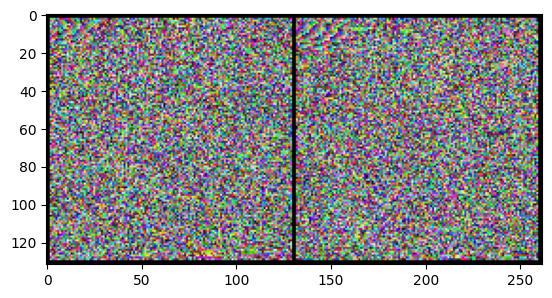

In [59]:
# Reversed Encoding
data = make_grid(liste_of_reversed_tensor[-1].cpu())
data = data.permute(1,2,0)
print(data.shape)
data_np = np.array((data*255), dtype=np.uint8)
plt.imshow(data_np)


In [19]:
with torch.no_grad():
    ddim_decode_sample = diffusion.ddim_sample_loop_progressive(gta_ema_model, x_0.shape, noise=None, 
                                                                eta=0.)
    liste_of_generated_tensor_city = []
    for dic in tqdm(ddim_decode_sample):
        liste_of_generated_tensor_city.append(dic['sample'])
        

6it [00:34,  5.67s/it]


KeyboardInterrupt: 

In [74]:
batch_size = 16
micro = 1
microbatch = micro if (micro is not None and micro > 0)  else batch_size

In [75]:
microbatch

1

torch.Size([132, 262, 3])


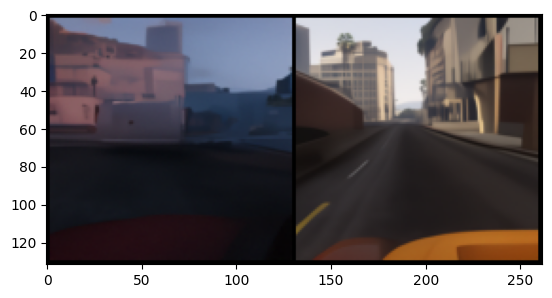

In [63]:
# Decoding
data = make_grid(liste_of_generated_tensor_city[-1].cpu())
data = data.permute(1,2,0)
print(data.shape)
data_np = np.array((data*255), dtype=np.uint8)
plt.imshow(data_np)


torch.Size([132, 262, 3])


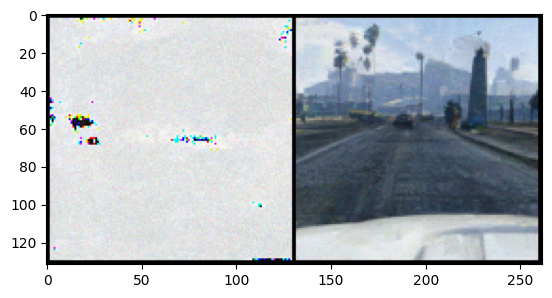

In [48]:
# Decoding
data = make_grid(liste_of_generated_tensor[-1].cpu())
data = data.permute(1,2,0)
print(data.shape)
data_np = np.array((data*255), dtype=np.uint8)
plt.imshow(data_np)


In [88]:
ddim_gta_sample = gta_ema_sampler.ddim_sample_loop_progressive(x_0.shape,  eta=0.)
liste_of_sampled_tensor = []
for dic in tqdm(ddim_gta_sample):
    liste_of_sampled_tensor.append(dic['sample'].cpu())

1000it [01:07, 14.90it/s]


In [96]:
del liste_of_sampled_tensor
del liste_of_generated_tensor
del liste_of_reversed_tensor
torch.cuda.empty_cache()
import gc
gc.collect()

7889

torch.Size([132, 262, 3])


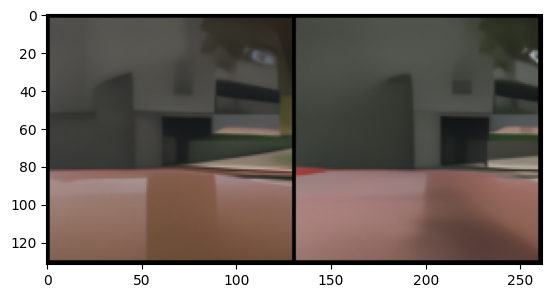

In [90]:
# Decoding
data = make_grid(liste_of_sampled_tensor[-1].cpu())
data = data.permute(1,2,0)
print(data.shape)
# data_np = np.array((data*255), dtype=np.uint8)
plt.imshow(data_np)

In [107]:
with torch.no_grad():
    sample = gta_ema_sampler(torch.randn_like(x_0).cuda(3))

In [113]:
sample.shape

torch.Size([2, 3, 128, 128])

In [109]:
liste_of_sampled_tensor = []
for dic in tqdm(sample):
    liste_of_sampled_tensor.append(dic['sample'].cpu())

  0%|                                                                                                                                                                                                | 0/2 [00:00<?, ?it/s]


IndexError: too many indices for tensor of dimension 3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([132, 262, 3])


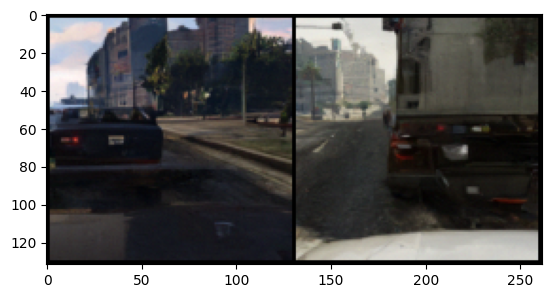

In [115]:
data = make_grid(sample.cpu())
data = data.permute(1,2,0)
print(data.shape)
# data_np = np.array((data*255), dtype=np.uint8)
plt.imshow(data)

In [ ]:
ddim_gta_sample = gta_ema_sampler.ddim_sample_loop(x_0.shape,  eta=0.)

In [7]:
### IMAGENET-C
from PIL import Image
image_path = "/mnt/scitas/datasets/imagenet/imagenet-c/contrast/1/n03062245/ILSVRC2012_val_00001471.JPEG"
transform = transforms.Compose(
                [   transforms.Resize([1024,2048]),
                    transforms.Resize([256,512]),
                    transforms.RandomCrop([256, 256]),
                    transforms.ToTensor(),
                ]
            )
simple_transform = transforms.ToTensor()
X = Image.open(image_path).convert("RGB")
img = simple_transform(X)


In [8]:
img.shape

torch.Size([3, 224, 224])

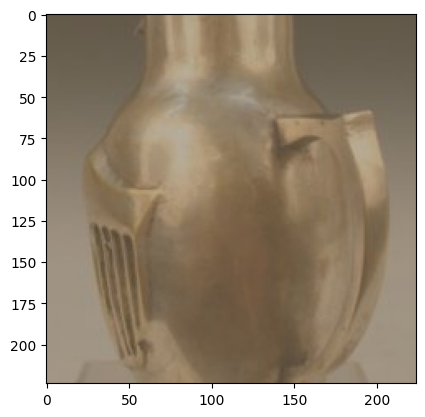

In [9]:
plt.imshow(X)